# The NBA Fatigue Factor

### Jeffrey Wang

## Introduction

For this project, I analyzed NBA game schedules to determine whether uncontrollable factors such as rest time and travel distance give teams a significant advantage/disadvantage.

Specifically, my goal was to estimate how many **wins/losses** were determined by **schedule-related factors** in the 2023 to 2024 NBA season.

To accomplish this, I engineered a **linear regression model** to analyze the impact of fatigue-related factors (rest time, travel distance, and time zone shifts) along with team rating and home/away status.


## Setup

I started by importing packages and loading/previewing the provided data.

In [153]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Load data
schedule = pd.read_csv("./data/schedule.csv")
game_data = pd.read_csv("./data/game_data.csv")
locations = pd.read_csv("./data/locations.csv")

Below are previews of the 3 data frames that I loaded.

In [154]:
schedule.head()  # Basic data frame focused on game dates

,season,gamedate,team,opponent,home,win
0,2014,2015-04-15,SAC,LAL,0,1
1,2014,2015-04-15,NYK,DET,1,0
2,2014,2015-04-15,DEN,GSW,0,0
3,2014,2015-04-15,MIA,PHI,0,1
4,2014,2015-04-15,UTA,HOU,0,0


In [155]:
game_data.head()  # Data frame containing team stats for each game (2 rows per game, 1 row per team)

,season,gametype,nbagameid,gamedate,offensivenbateamid,off_team_name,off_team,off_home,off_win,defensivenbateamid,...,turnovers,blocksagainst,defensivefouls,offensivefouls,shootingfoulsdrawn,possessions,points,shotattempts,andones,shotattemptpoints
0,2016,2,21600495,2016-12-30,1610612740,New Orleans Pelicans,NOP,1,1,1610612752,...,13,6,17,1,9,101,104,91,3,102
1,2016,2,21600495,2016-12-30,1610612752,New York Knicks,NYK,0,0,1610612740,...,14,5,11,1,9,99,92,100,2,92
2,2021,2,22100943,2022-03-03,1610612742,Dallas Mavericks,DAL,1,1,1610612744,...,10,5,16,0,11,90,122,90,6,120
3,2021,2,22100943,2022-03-03,1610612744,Golden State Warriors,GSW,0,0,1610612742,...,15,1,16,3,6,90,113,86,1,112
4,2016,2,21601032,2017-03-18,1610612741,Chicago Bulls,CHI,1,1,1610612762,...,11,8,11,0,6,88,95,84,2,92


In [156]:
locations.head()  # Data frame containing the location of arenas

,team,latitude,longitude,timezone
0,ATL,33.757233,-84.396340,Eastern
1,BOS,42.366310,-71.062226,Eastern
2,BKN,40.682657,-73.975282,Eastern
3,CHA,35.225186,-80.839336,Eastern
4,CHI,41.880629,-87.674048,Central


First, I performed some basic transformations to optimize data querying.

In [157]:
# Convert dates from string to date type
schedule['gamedate'] = pd.to_datetime(schedule['gamedate'])
game_data['gamedate'] = pd.to_datetime(game_data['gamedate'])

# Set nbagameid from game_data as a single-column index in schedule for efficiency
schedule = (
    schedule
    .merge(game_data, left_on=['season', 'gamedate', 'team', 'opponent'], right_on=['season', 'gamedate', 'off_team', 'def_team'])
    .set_index('nbagameid')
    [['season', 'gamedate', 'team', 'opponent', 'home', 'win']]
)

# Set nbagameid as game_data index
game_data = game_data.set_index('nbagameid')

After exploring the provided data, I determined that the most impactful factors on game results were team rating, home-field advantage, rest time, travel distance, and directional time zone shifts.

As a result, I designed my model around these features.

## Team Rating

First, I needed to figure out a reliable way to measure team strength for the "team rating" feature.

To rate teams, I determined that the best metric to use would be **offensive/defensive rating** (points scored/allowed per 100 possessions), since these stats are comprehensive, have relatively low overlap (multicollinearity), and account for game length (possessions).

Furthermore, I decided to use net rating as my model's target variable (team offensive rating - team defensive rating). Positive/negative net rating is directly correlated to win/loss, and it also provides the model with information regarding the margin of victory and game length.

As a result, I set out to calculate the offensive/defensive/net ratings for each game.

In [158]:
# Calculate efficiency (points per possession * 100), the foundation for offensive/defensive rating
eff_df = game_data.copy()  # Use a copy to avoid modifying original data
eff_df['efficiency'] = 100 * eff_df['points'] / eff_df['possessions']

# Create a simplified view for merge
eff_view = eff_df[['off_team', 'efficiency']].rename(columns={'off_team': 'team'})

eff_view.head()

,team,efficiency
nbagameid,,
21600495,NOP,102.970297
21600495,NYK,92.929293
22100943,DAL,135.555556
22100943,GSW,125.555556
21601032,CHI,107.954545


In [159]:
# Self-join on nbagameid to get offensive/defensive rating (efficiency)
rating_df = (
    eff_view
    .join(eff_view, how='inner', lsuffix='_x', rsuffix='_y')  # Self-join on nbagameid
    .query('team_x != team_y')  # Avoid unintentional rows where teams play against themselves
    .rename(columns={'team_x': 'team', 'team_y': 'opponent', 'efficiency_x': 'offensive_rating', 'efficiency_y': 'defensive_rating'})
    [['team', 'opponent', 'offensive_rating', 'defensive_rating']]  # Reorder columns for readability
)

# Calculate net rating (later used for model target)
rating_df['net_rating'] = rating_df['offensive_rating'] - rating_df['defensive_rating']

rating_df.head()

,team,opponent,offensive_rating,defensive_rating,net_rating
nbagameid,,,,,
21600495,NOP,NYK,102.970297,92.929293,10.041004
21600495,NYK,NOP,92.929293,102.970297,-10.041004
22100943,DAL,GSW,135.555556,125.555556,10.000000
22100943,GSW,DAL,125.555556,135.555556,-10.000000
21601032,CHI,UTA,107.954545,97.727273,10.227273


Now that we have every team's ratings per game, we need a way to consolidate them into a representation of a team's strength at a certain point in time (simply using a team's rating from the previous game is not enough).

## Data Leakage

The most intuitive way to represent a team's strength during a season would be calculating its ***average offensive/defensive ratings*** that season; however, this would introduce ***data leakage*** to the model since the average would contain information from future games. For example, during the first game of a season, the model would already know the average performance of both teams throughout the rest of the season.

A better alternative would be to use a team's strength from the ***previous season***, but this is not a reliable method because team strength shifts significantly during the off-season. I actually tried this method at first, but the model performance was lackluster.

Instead, the most effective approach was to use a ***moving average rating*** based on the preceding n games. The method that gave me the best results was EWMA (exponentially weighted moving average), which is a moving average that gives recent games more weight. This allows the model to quickly adjust to any hot streaks, injuries, or recent trades that a team could be experiencing.

In [160]:
# Add seasons/dates and sort for moving average calculations
dates = schedule.copy()[['season', 'gamedate']]
rating_df = dates.join(rating_df, how='inner').drop_duplicates().sort_values(['team', 'gamedate'])
rating_df.sort_index().head()

,season,gamedate,team,opponent,offensive_rating,defensive_rating,net_rating
nbagameid,,,,,,,
21400001,2014,2014-10-28,NOP,ORL,107.446809,89.361702,18.085106
21400001,2014,2014-10-28,ORL,NOP,89.361702,107.446809,-18.085106
21400002,2014,2014-10-28,DAL,SAS,117.647059,118.823529,-1.176471
21400002,2014,2014-10-28,SAS,DAL,118.823529,117.647059,1.176471
21400003,2014,2014-10-28,HOU,LAL,116.129032,95.744681,20.384351


In [161]:
MOVING_WINDOW = 20  # Window = 20 games

# Calculate lagged moving average offensive rating
rating_df['moving_avg_ortg'] = (
    rating_df
    .groupby('team')['offensive_rating']
    # EWMA gives more weight to recent performance, which captures hot streaks, injuries, and recent trades much better than a standard moving window
    .transform(lambda x: x.shift().ewm(MOVING_WINDOW).mean())
)

# Calculate lagged moving average defensive rating
rating_df['moving_avg_drtg'] = (
    rating_df
    .groupby('team')['defensive_rating']
    # EWMA gives more weight to recent performance, which captures hot streaks, injuries, and recent trades much better than a standard moving window
    .transform(lambda x: x.shift().ewm(MOVING_WINDOW).mean())

)

rating_df.dropna().head()  # First 20 rows contain NaN values due to window size

,season,gamedate,team,opponent,offensive_rating,defensive_rating,net_rating,moving_avg_ortg,moving_avg_drtg
nbagameid,,,,,,,,,
21400032,2014,2014-11-01,ATL,IND,108.510638,98.924731,9.585907,108.510638,115.957447
21400064,2014,2014-11-05,ATL,SAS,95.833333,97.916667,-2.083333,108.510638,107.233373
21400071,2014,2014-11-07,ATL,CHA,106.250000,107.964602,-1.714602,104.077100,103.975112
21400084,2014,2014-11-08,ATL,NYK,117.045455,109.090909,7.954545,104.660704,105.046620
21400100,2014,2014-11-10,ATL,NYK,102.247191,93.406593,8.840598,107.385051,105.936266


## Travel Fatigue

Now that we have a reliable way to measure team strength, the next step is to determine metrics for travel fatigue.

On top of the obvious **travel distance feature**, I also included a **time zone shift** feature after reading that teams who travel east tend to perform better than teams who travel west due to circadian rhythm shifts. This feature is negative when the team is traveling west, and positive when the team is traveling east, distinguishing it from travel distance, which is positive no matter which direction the team is going.

In [162]:
# Set up data frame for distance and time shift calculation
travel_df = schedule.copy()  # Use a copy to avoid modifying original data

# Identify arena where game is played
travel_df['arena'] = np.where(travel_df['home'] == 1, travel_df['team'], travel_df['opponent'])

# Merge locations to get latitude and longitude for arena
travel_df = (
    travel_df
    .reset_index()
    .merge(locations.rename(columns={'team': 'arena'}), on='arena')
    .set_index('nbagameid')
)

# Represent time zones numerically
time_zone_map = {
    'Pacific': 0,
    'Mountain': 1,
    'Central': 2,
    'Eastern': 3
}

# Map time zones to codes
travel_df['timezone'] = travel_df['timezone'].map(time_zone_map)

travel_df.sort_index().head()

,season,gamedate,team,opponent,home,win,arena,latitude,longitude,timezone
nbagameid,,,,,,,,,,
21400001,2014,2014-10-28,NOP,ORL,1,1,NOP,29.949003,-90.081904,2
21400001,2014,2014-10-28,ORL,NOP,0,0,NOP,29.949003,-90.081904,2
21400002,2014,2014-10-28,DAL,SAS,0,0,SAS,29.427002,-98.437482,2
21400002,2014,2014-10-28,SAS,DAL,1,1,SAS,29.427002,-98.437482,2
21400003,2014,2014-10-28,LAL,HOU,1,0,LAL,34.043006,-118.267360,0


In [163]:
# Transformations for distance calculation
travel_df = (
        travel_df
        .sort_values(['season', 'team', 'gamedate'])  # Sort by date to prepare for distance calculation
        .reset_index()  # For preserving nbagameid index
        # Identify origin (home) coordinates for filling starting point NaNs at the beginning of a season
        .merge(locations.rename(columns={'latitude': 'origin_lat', 'longitude': 'origin_lon', 'timezone': 'origin_zone'}), on='team')
        .set_index('nbagameid')
        .rename(columns={'arena': 'end_arena', 'latitude': 'end_lat', 'longitude': 'end_lon', 'timezone': 'end_zone'})  # Rename for clarity
)

# Map origin time zones to codes
travel_df['origin_zone'] = travel_df['origin_zone'].map(time_zone_map)

# Shift to get previous game coordinates for calculating travel distance
# Groups reset origin per team/season; defaults to home arena for the first game of each year
travel_df['start_arena'] = travel_df.groupby(['season', 'team'])['end_arena'].shift().fillna(travel_df['team'])
travel_df['start_lat'] = travel_df.groupby(['season', 'team'])['end_lat'].shift().fillna(travel_df['origin_lat'])
travel_df['start_lon'] = travel_df.groupby(['season', 'team'])['end_lon'].shift().fillna(travel_df['origin_lon'])
travel_df['start_zone'] = travel_df.groupby(['season', 'team'])['end_zone'].shift().fillna(travel_df['origin_zone']).astype(int)

# Calculate haversine distance between start and end coordinates
travel_df['km_traveled'] = travel_df.apply(lambda row: haversine((row['start_lat'], row['start_lon']), (row['end_lat'], row['end_lon'])), axis = 1)

# Calculate time shift between start and end time zones
travel_df['time_zone_shift'] = travel_df['end_zone'] - travel_df['start_zone']

# Organize data frame for display
travel_df = (
        travel_df
        [[  # Drop temporary columns and reorder for readability
                'season', 'gamedate', 
                'team', 'opponent', 'home', 
                'start_arena', 'start_lat', 'start_lon', 
                'end_arena', 'end_lat', 'end_lon', 
                'km_traveled', 
                'start_zone', 'end_zone', 'time_zone_shift'
        ]]
)

travel_df.sort_index().head(10)

,season,gamedate,team,opponent,home,start_arena,start_lat,start_lon,end_arena,end_lat,end_lon,km_traveled,start_zone,end_zone,time_zone_shift
nbagameid,,,,,,,,,,,,,,,
21400001,2014,2014-10-28,NOP,ORL,1,NOP,29.949003,-90.081904,NOP,29.949003,-90.081904,0.000000,2,2,0
21400001,2014,2014-10-28,ORL,NOP,0,ORL,28.538954,-81.384276,NOP,29.949003,-90.081904,858.080840,3,2,-1
21400002,2014,2014-10-28,DAL,SAS,0,DAL,32.790314,-96.810148,SAS,29.427002,-98.437482,404.786229,2,2,0
21400002,2014,2014-10-28,SAS,DAL,1,SAS,29.427002,-98.437482,SAS,29.427002,-98.437482,0.000000,2,2,0
21400003,2014,2014-10-28,HOU,LAL,0,HOU,29.750907,-95.362061,LAL,34.043006,-118.267360,2209.366321,2,0,-2
21400003,2014,2014-10-28,LAL,HOU,1,LAL,34.043006,-118.267360,LAL,34.043006,-118.267360,0.000000,0,0,0
21400004,2014,2014-10-29,CHA,MIL,1,CHA,35.225186,-80.839336,CHA,35.225186,-80.839336,0.000000,3,3,0
21400004,2014,2014-10-29,MIL,CHA,0,MIL,43.043625,-87.916838,CHA,35.225186,-80.839336,1061.378300,2,3,1
21400005,2014,2014-10-29,IND,PHI,1,IND,39.763990,-86.155566,IND,39.763990,-86.155566,0.000000,3,3,0


## Rest Time

Finally, the last feature I prepared was rest time. The challenge here is modeling the **diminishing returns** of rest.

I started out by setting a rest-day cap and applying a log transformation to rest days to model the diminishing return; however, I was unhappy with the lack of representation of cumulative fatigue.

**By simply tracking rest days between games, I was ignoring the impact of cumulative fatigue across multi-game stretches.**

To account for this, I decided on using categorical encoding, with categories representing back-to-back, 3-in-4, 4-in-6, and 5-in-7. Although these categories are highly correlated, my goal was to see which ones were significant enough to be included, before fine-tuning the model to reduce multicollinearity.

It is worth noting that I left out 4-in-5 stretches. This is because the NBA banned them in the 2017 season, so my model will only be using data from this time onwards.

In [164]:
# Sort the data frame for counting rest days
rest_df = schedule.copy().sort_values(['season', 'team', 'gamedate'])  # Use a copy to avoid modifying original data

# Cap rest at 4 days (diminishing returns)
REST_CAP = 4

# Count rest days before each game for is_b2b calculation
rest_df['rest_days'] = (
    rest_df.groupby(['season', 'team'])['gamedate']
    .diff()
    .dt.days.sub(1)  # Back-to-back games are considered 0 rest
    .fillna(REST_CAP)  # Teams are fully rested before the first game of a season
    .clip(upper=REST_CAP)
    .astype(int)
)

# Count games in the last 4, 5, 6, and 7 days, creating new games_in_n_days columns
for d in range(4, 8):
    rest_df[f'games_in_{d}_days'] = (
        rest_df.groupby(['season', 'team'])
        .rolling(f'{d}D', on='gamedate')['gamedate']
        .count()
        .values
    ).astype(int)

# Create rest categories for b2b, 3-in-4, 4-in-6, and 5-in-7
# These features have high multicollinearity (e.g. a 3-in-4 stretch always includes a b2b), 
# so we'll update the model later after seeing their impact
rest_df['is_b2b'] = (rest_df['rest_days'] == 0).astype(int)
rest_df['is_3in4'] = (rest_df['games_in_4_days'] >= 3).astype(int)
# 4-in-5s were eliminated in the 2017 season
rest_df['is_4in6'] = (rest_df['games_in_6_days'] >= 4).astype(int)
rest_df['is_5in7'] = (rest_df['games_in_7_days'] >= 5).astype(int)

rest_df = rest_df[[
    'season', 'gamedate', 
    'team', 'opponent',
    'rest_days', 'is_b2b',
    'games_in_4_days', 'is_3in4',
    'games_in_6_days', 'is_4in6',
    'games_in_7_days', 'is_5in7',
]]

rest_df.head(10)

,season,gamedate,team,opponent,rest_days,is_b2b,games_in_4_days,is_3in4,games_in_6_days,is_4in6,games_in_7_days,is_5in7
nbagameid,,,,,,,,,,,,
21400008,2014,2014-10-29,ATL,TOR,4,0,1,0,1,0,1,0
21400032,2014,2014-11-01,ATL,IND,2,0,2,0,2,0,2,0
21400064,2014,2014-11-05,ATL,SAS,3,0,1,0,2,0,2,0
21400071,2014,2014-11-07,ATL,CHA,1,0,2,0,2,0,3,0
21400084,2014,2014-11-08,ATL,NYK,0,1,3,1,3,0,3,0
21400100,2014,2014-11-10,ATL,NYK,1,0,3,1,4,1,4,0
21400110,2014,2014-11-12,ATL,UTA,1,0,2,0,4,1,4,0
21400124,2014,2014-11-14,ATL,MIA,1,0,2,0,3,0,4,0
21400133,2014,2014-11-15,ATL,CLE,0,1,3,1,4,1,4,0


## Compiling Data

Finally, with the completion of my team rating, travel fatigue, and rest time data frames, I can combine them into a cohesive dataset for my model.

The key in this step is taking the differences of features between the two competing teams for **model symmetry**. For example, instead of km_traveled, the feature now becomes the km_traveled_diff, the difference between the travel distance of the two teams. Without this step, the model might erroneously believe that being the "team" versus being the "opponent" in the dataset has different effects, which is untrue.

Since the dataset originally has two rows per game, this could technically be avoided, but I end up reducing the dataset into 1 row per game to avoid inflated p-values for coefficients. Because the purpose of the model is to identify which features are significant to team performance, having inflated p-values here would be unideal.

In [165]:
# These metrics will be combined with metrics from the opposing team to form a "whole" feature
# e.g. km_traveled will become km_traveled_diff, the difference between the commute distances of the two teams
partial_features = [
    'is_home', 
    'moving_avg_ortg', 'moving_avg_drtg', 
    'km_traveled', 'time_zone_shift',
    'is_b2b', 'is_3in4', 'is_4in6', 'is_5in7'
]

# Model target variable, net rating indicates the winning team and the winning margin relative to game length
target = 'net_rating'

def build_partial_df(ratings_df, travel_df, rest_df, partial_features, target):
    '''Builds one side of the model data frame, accounting for the features of one team.'''

    # Columns for filtering observations later on
    metadata = ['season', 'gamedate', 'team', 'opponent']

    # Join rating, travel, and rest data frames
    partial_df = (
        rating_df
        .reset_index()
        .merge(travel_df, on=metadata)
        .merge(rest_df, on=metadata)
        .set_index('nbagameid')
    )

    # Improve column name for clarity 
    partial_df = partial_df.rename(columns={'home': 'is_home'})

    # Select feature and target columns
    partial_df = partial_df[metadata + partial_features + [target]]  # Game ID necessary for final merge

    return partial_df

partial_df = build_partial_df(rating_df, travel_df, rest_df, partial_features, target)  # Build team data frame
partial_df.dropna().sort_values('gamedate').head(10)

,season,gamedate,team,opponent,is_home,moving_avg_ortg,moving_avg_drtg,km_traveled,time_zone_shift,is_b2b,is_3in4,is_4in6,is_5in7,net_rating
nbagameid,,,,,,,,,,,,,,
21400013,2014,2014-10-29,LAL,PHX,0,95.744681,116.129032,576.648504,1,1,0,0,0,-21.276596
21400012,2014,2014-10-29,HOU,UTA,0,116.129032,95.744681,935.047050,1,1,0,0,0,9.873737
21400016,2014,2014-10-30,WAS,ORL,0,104.395604,116.304348,328.692397,0,1,0,0,0,6.217105
21400020,2014,2014-10-30,OKC,LAC,0,101.136364,123.255814,1331.063793,0,1,0,0,0,-5.111232
21400016,2014,2014-10-30,ORL,WAS,1,89.361702,107.446809,858.080840,1,0,0,0,0,-6.217105
21400019,2014,2014-10-30,DAL,UTA,1,117.647059,118.823529,404.786229,0,0,0,0,0,19.780220
21400018,2014,2014-10-30,NYK,CLE,0,89.887640,118.181818,649.612601,0,1,0,0,0,7.212885
21400017,2014,2014-10-30,DET,MIN,0,83.157895,94.680851,1124.103138,1,1,0,0,0,-9.116162
21400017,2014,2014-10-30,MIN,DET,1,105.208333,109.375000,1127.948643,0,1,0,0,0,9.116162


In [166]:
def build_full_df(partial_df, partial_features, target):
    '''Builds the full model data frame by taking the differences of features from the teams who are competing.'''

    metadata = ['team', 'opponent', 'season', 'gamedate']
    duplicate_columns = ['is_home', target]  # Columns to drop before self-join

    # Self-join partial_df on nbagameid for feature comparison between two teams
    full_df = (
        partial_df
        .reset_index()  # For reconfiguring nbagameid index
        .merge(partial_df.drop(columns=duplicate_columns), left_on=['season', 'gamedate', 'team'], right_on=['season', 'gamedate', 'opponent'])
        .drop_duplicates(subset=['nbagameid'], keep='first')  # Drop duplicate observations, initially 2 observations per game (each team's perspective)
        .dropna()
        .drop(columns=['team_y', 'opponent_y'])
        .rename(columns={'team_x': 'team', 'opponent_x': 'opponent'})
        .set_index('nbagameid')
    )

    # Calculate cross ratings
    full_df['cross_rating_x'] = full_df['moving_avg_ortg_x'] + full_df['moving_avg_drtg_y']
    full_df['cross_rating_y'] = full_df['moving_avg_ortg_y'] + full_df['moving_avg_drtg_x']

    # Calculate _diff features (e.g. km_traveled_diff = km_traveled_x - km_traveled_y)
    # Assign features for _diff calculation
    exclude = {'is_home', 'moving_avg_ortg', 'moving_avg_drtg'}
    diff_features = ['cross_rating'] + [f for f in partial_features if f not in exclude]
    
    # Initial list for storing _diff feature names
    full_diff_features = []

    # Calculate _diff features
    for feature in diff_features:
        full_df[f'{feature}_diff'] = full_df[f'{feature}_x'] - full_df[f'{feature}_y']  # Create new column in data frame for _diff feature
        full_diff_features.append(f'{feature}_diff')  # Track _diff feature column names

    # Filter useful columns
    full_features = ['is_home'] + full_diff_features
    full_df = full_df[metadata + full_features + ['net_rating']]
    return full_df, full_features

full_df, full_features = build_full_df(partial_df, partial_features, target)
full_df.sort_values('gamedate').head(10)

,team,opponent,season,gamedate,is_home,cross_rating_diff,km_traveled_diff,time_zone_shift_diff,is_b2b_diff,is_3in4_diff,is_4in6_diff,is_5in7_diff,net_rating
nbagameid,,,,,,,,,,,,,
21400019,DAL,UTA,2014,2014-10-30,1,8.697267,-1202.003722,-1,-1,0,0,0,19.780220
21400017,DET,MIN,2014,2014-10-30,0,-7.356290,-3.845505,1,0,0,0,0,-9.116162
21400016,ORL,WAS,2014,2014-10-30,1,-6.176363,529.388443,1,-1,0,0,0,-6.217105
21400023,MIL,PHI,2014,2014-10-31,1,14.214479,668.250784,0,0,0,0,0,13.079777
21400026,LAC,LAL,2014,2014-10-31,0,25.952586,-576.648504,1,1,-1,0,0,5.785284
21400021,IND,MEM,2014,2014-10-31,1,10.981344,-618.536844,-1,0,0,0,0,-9.090909
21400024,PHX,SAS,2014,2014-10-31,1,20.100125,-1367.180952,1,0,0,0,0,7.493062
21400025,POR,SAC,2014,2014-10-31,0,40.313998,778.910270,0,0,0,0,0,-10.000000
21400022,CHI,CLE,2014,2014-10-31,1,35.507063,649.421289,0,-1,0,0,0,-4.761016


Quick note on the cross_rating_diff feature: here, a team's cross rating is its offensive rating (moving average) minus the opponent's defensive rating (moving average). The cross rating difference is the difference between a team's cross rating and its opponent's cross rating. In order to maintain model symmetry, it is the only feature in my model that measures the relative strength of the two teams.

## Standardizing Data

Now that the data has all been compiled into one data frame, we are almost finished!

The last step before feeding the data into the model is standardizing the data. This step centers the data around a mean of 0 with a standard deviation of 1, which puts features of different units and magnitudes on a level playing field.

In [167]:
full_df_post_2017 = full_df[full_df['season'] >= 2017]

def scale_model_df(full_df, full_features, target, binary_features):
    '''Scale features for model training while preserving metadata'''
    scaler = StandardScaler()

    # Avoid scaling binary features to preserve interpretability
    features_to_scale = [f for f in full_features if f not in binary_features]

    # Scaled features (ensure index matches original to prevent misalignment)
    X_scaled = pd.DataFrame(
        scaler.fit_transform(full_df[features_to_scale]), 
        columns=features_to_scale, 
        index=full_df.index
    )
    
    # Extract metadata and target
    metadata = ['team', 'opponent', 'season', 'gamedate']
    y = full_df[target]

    # Merge parts
    model_df = pd.concat([full_df[metadata], X_scaled, full_df[binary_features]], axis=1)  # Concatenate horizontally
    model_df[target] = y  # Add target back

    return model_df

# Features to avoid scaling
# is_home is an exception because we want it to be 1 / -1 due to its symmetry
binary_features = [
    'is_b2b_diff', 'is_3in4_diff', 'is_4in6_diff', 'is_5in7_diff'
]

# Scale features and set target
model_df = scale_model_df(full_df_post_2017, full_features, target, binary_features)

# Round is_home to 1 or -1
model_df['is_home'] = np.round(model_df['is_home'])

model_df.head(10)

,team,opponent,season,gamedate,is_home,cross_rating_diff,km_traveled_diff,time_zone_shift_diff,is_b2b_diff,is_3in4_diff,is_4in6_diff,is_5in7_diff,net_rating
nbagameid,,,,,,,,,,,,,
21700009,ATL,DAL,2017,2017-10-18,-1.0,0.448296,0.908551,-0.889394,0,0,0,0,7.099010
21700017,ATL,CHA,2017,2017-10-20,-1.0,0.221765,0.532711,0.944028,0,0,0,0,-18.705106
21700038,ATL,BKN,2017,2017-10-22,-1.0,0.351068,0.669084,0.027317,0,0,0,0,-11.538462
21700042,ATL,MIA,2017,2017-10-23,-1.0,-0.842084,1.377052,0.027317,1,1,1,0,-11.920792
21700065,ATL,CHI,2017,2017-10-26,-1.0,-0.530784,1.113176,0.027317,0,0,0,0,-6.605617
21700072,ATL,DEN,2017,2017-10-27,1.0,-0.566631,0.455918,0.944028,1,0,1,0,-4.143337
21700085,ATL,MIL,2017,2017-10-29,1.0,-0.198352,-0.850905,-0.889394,0,1,0,0,-12.049505
21700107,ATL,PHI,2017,2017-11-01,-1.0,0.274724,-0.858303,-0.889394,0,0,0,0,-9.009009
21700123,ATL,HOU,2017,2017-11-03,1.0,-0.947685,-0.110747,0.027317,0,0,0,0,-15.151515


## Modeling

Finally, we can model the data. I used an ordinary least squares (linear regression) model from the statsmodels library to inspect feature p-values.

Because the model is used for explanatory purposes, there is no need to split my data into training, validation, and test sets.

In [168]:
linear_model = sm.OLS(model_df[target], model_df[full_features]).fit()  # Ordinary least squares

linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             net_rating   R-squared (uncentered):                   0.164
Model:                            OLS   Adj. R-squared (uncentered):              0.163
Method:                 Least Squares   F-statistic:                              202.8
Date:                Fri, 06 Feb 2026   Prob (F-statistic):                   8.82e-315
Time:                        23:34:23   Log-Likelihood:                         -33485.
No. Observations:                8289   AIC:                                  6.699e+04
Df Residuals:                    8281   BIC:                                  6.704e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
is_home                  1.9881      0.171     11.645      0.000       1.653       2.323
cross_rating_diff        5.5772      0.151     36.890      0.000       5.281       5.874
km_traveled_diff        -0.0376      0.170     -0.221      0.825      -0.371       0.296
time_zone_shift_diff    -0.0848      0.151     -0.561      0.575      -0.381       0.212
is_b2b_diff             -1.9619      0.355     -5.529      0.000      -2.658      -1.266
is_3in4_diff            -0.3130      0.347     -0.902      0.367      -0.993       0.367
is_4in6_diff            -0.6371      0.304     -2.096      0.036      -1.233      -0.041
is_5in7_diff             0.1164      0.833      0.140      0.889      -1.516       1.749
==============================================================================
Omnibus:                       42.169   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.077
Skew:                           0.055   Prob(JB):                     4.04e-13
Kurtosis:                       3.391   Cond. No.                         6.66
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model Takeaways

From this summary, we can see that `is_home`, `cross_rating_diff`, `is_b2b_diff`, and `is_4in6_diff` all have a p-value under 0.05, which means that they are likely to be statistically significant. 

The other features, `km_traveled_diff`, `time_zone_shift_diff`, `is_3in4_diff`, and `is_5in7_diff` all have very high p-values, so they are likely to be statistically insignificant. 

Distance and direction (time zone) traveled may no longer be a significant issue post-2017 due to teams having luxury transportation methods and accommodations that mitigate the toll of travel.

3-in-4 stretches and 5-in-7 stretches are likely insignificant because of their high overlap with back-to-back and 4-in-6 stretches, which the model believes are the true culprits for teams underperforming from exhaustion.

## Improved Model

Because these features are insignificant, I removed them and built a new model that only uses statistically significant features.

Furthermore, I modified the rest categories to reduce overlap by introducing three mutually exclusive bins: `is_b2b_not_4in6`, `is_4in6_not_b2b`, and `is_b2b_and_4in6`. These features, along with the implied baseline of `not_b2b_not_4in6` will allow the model to learn the individual and combined effects of back-to-back and 4-in-6 stretches.

In [169]:
# It turns out, only b2bs and 4-in-6s are relevant (see model summary below for details)
# Create bins for mutually exclusive rest categories
rest_df['is_b2b_not_4in6'] = np.maximum(rest_df['is_4in6'] - rest_df['is_b2b'], 0)
rest_df['is_4in6_not_b2b'] = np.maximum(rest_df['is_b2b'] - rest_df['is_4in6'], 0)
rest_df['is_b2b_and_4in6'] = rest_df['is_b2b'] * rest_df['is_4in6']
# Baseline is not_b2b_not_4in6

new_partial_features = [
    'is_home', 
    'moving_avg_ortg', 'moving_avg_drtg', 
    'is_b2b_not_4in6', 'is_4in6_not_b2b', 'is_b2b_and_4in6'
]

target = 'net_rating'

new_binary_features = ['is_b2b_not_4in6_diff', 'is_4in6_not_b2b_diff', 'is_b2b_and_4in6_diff']

# Compile and standardize data for new model
new_partial_df = build_partial_df(rating_df, travel_df, rest_df, new_partial_features, target)
new_full_df, new_full_features = build_full_df(new_partial_df, new_partial_features, target)
new_full_df_post_2017 = new_full_df[new_full_df['season'] >= 2017]
new_model_df = scale_model_df(new_full_df_post_2017, new_full_features, target, new_binary_features)

# Build new model
new_linear_model = sm.OLS(new_model_df[target], new_model_df[new_full_features]).fit()  # Ordinary least squares

# Summarize model
new_linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             net_rating   R-squared (uncentered):                   0.164
Model:                            OLS   Adj. R-squared (uncentered):              0.163
Method:                 Least Squares   F-statistic:                              324.4
Date:                Fri, 06 Feb 2026   Prob (F-statistic):                   3.12e-318
Time:                        23:34:23   Log-Likelihood:                         -33486.
No. Observations:                8289   AIC:                                  6.698e+04
Df Residuals:                    8284   BIC:                                  6.702e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
is_home                  2.0082      0.152     13.207      0.000       1.710       2.306
cross_rating_diff        5.5768      0.151     36.914      0.000       5.281       5.873
is_b2b_not_4in6_diff    -0.7500      0.294     -2.551      0.011      -1.326      -0.174
is_4in6_not_b2b_diff    -2.0202      0.438     -4.615      0.000      -2.878      -1.162
is_b2b_and_4in6_diff    -2.8614      0.382     -7.481      0.000      -3.611      -2.112
==============================================================================
Omnibus:                       42.240   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.277
Skew:                           0.054   Prob(JB):                     3.65e-13
Kurtosis:                       3.392   Cond. No.                         3.03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Results

The new model's features are much more explanatory than the old model's features, with `is_b2b_not_4in6`, `is_4in6_not_b2b`, and `is_b2b_and_4in6` all being statistically significant. Most notably, team performance fell by an average of **2.02 points** in the fourth game of a 4-in-6 stretch, with the drop increasing to **2.86 points** when that game was also part of a back-to-back.

With the new model finished, it's time to use its coefficients to estimate how much schedule-related factors (home-team advantage and rest advantage) impacted total wins in the 2023 to 2024 season.

In [170]:
# Filter for the 2023 season's data
results_df = new_model_df[new_model_df['season'] == 2023]

# Adjust net rating based on schedule-related factors using model coefficients
results_df['adjusted_net_rating'] = results_df['net_rating']
results_df['adjusted_net_rating'] -= new_linear_model.params['is_home'] * results_df['is_home']  # Rid home teams of home-team advantage
results_df['adjusted_net_rating'] -= new_linear_model.params['is_b2b_not_4in6_diff'] * results_df['is_b2b_not_4in6_diff']  # Remove disadvantages from rest disparity
results_df['adjusted_net_rating'] -= new_linear_model.params['is_4in6_not_b2b_diff'] * results_df['is_4in6_not_b2b_diff']
results_df['adjusted_net_rating'] -= new_linear_model.params['is_b2b_and_4in6_diff'] * results_df['is_b2b_and_4in6_diff']

# For each team, calculate actual and adjusted wins under both "team" and "opponent" labels
results_df['team_win'] = (results_df['net_rating'] >= 0).astype(int)
results_df['adjusted_team_win'] = (results_df['adjusted_net_rating'] >= 0).astype(int)
results_df['opponent_win'] = (results_df['net_rating'] < 0).astype(int)
results_df['adjusted_opponent_win'] = (results_df['adjusted_net_rating'] < 0).astype(int)

# Count actual and adjusted wins for each team
team_wins = results_df.groupby('team')['team_win'].sum()
opponent_wins = results_df.groupby('opponent')['opponent_win'].sum()
adjusted_team_wins = results_df.groupby('team')['adjusted_team_win'].sum()
adjusted_opponent_wins = results_df.groupby('opponent')['adjusted_opponent_win'].sum()

# Reshape the data so every game has two rows (one for each team)
all_games = pd.concat([
    results_df[['team', 'team_win', 'adjusted_team_win']].rename(
        columns={'team': 'team', 'team_win': 'actual_wins', 'adjusted_team_win': 'adjusted_wins'}),
    results_df[['opponent', 'opponent_win', 'adjusted_opponent_win']].rename(
        columns={'opponent': 'team', 'opponent_win': 'actual_wins', 'adjusted_opponent_win': 'adjusted_wins'})
])

# Group by team to get totals for all 30 teams
wins_df = all_games.groupby('team').sum()
wins_df['actual_diff'] = wins_df['actual_wins'] - wins_df['adjusted_wins']
wins_df = wins_df.sort_values(['actual_diff', 'actual_wins'], ascending=False)

wins_df

,actual_wins,adjusted_wins,actual_diff
team,,,
CLE,48,46,2
LAL,48,46,2
MIL,48,46,2
BOS,64,63,1
LAC,50,49,1
PHX,50,49,1
ATL,34,33,1
BKN,32,31,1
UTA,31,30,1


This table shows that the teams that gained the most from the 2023 to 2024 season schedule were the **Cleveland Cavaliers**, **Los Angeles Lakers**, and **Milwaukee Bucks**, who each netted 2 wins due to schedule-related factors.

On the other hand, the teams that were hurt the most by the schedule were the **Chicago Bulls** and **Toronto Raptors**, who each netted 3 losses due to schedule-related factors.

Finally, I'll build a simple visualiation to compare schedule-adjusted wins with actual wins from the 2023 to 2024 NBA season.

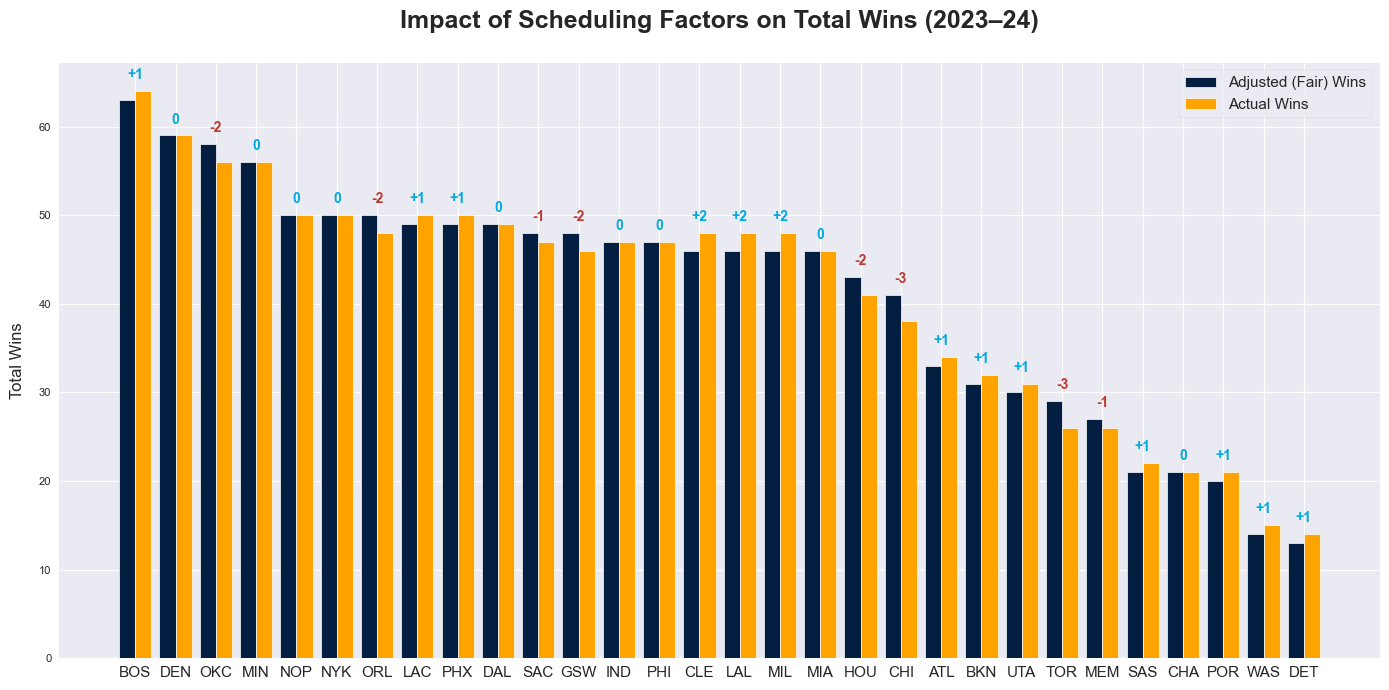

In [171]:
wins_df = wins_df.sort_values(['adjusted_wins', 'actual_wins'], ascending=False)

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(14, 7), dpi=100)
x = np.arange(len(wins_df.index))
width = 0.4

# Create bars (Swapped: Adjusted on left, Actual on right)
rects1 = ax.bar(x - width/2, wins_df['adjusted_wins'], width, label='Adjusted (Fair) Wins', color='#041e42', edgecolor='white', linewidth=0.5)
rects2 = ax.bar(x + width/2, wins_df['actual_wins'], width, label='Actual Wins', color='#ffa300', edgecolor='white', linewidth=0.5)

# Formatting
ax.set_ylabel('Total Wins', fontsize=12, labelpad=10)
ax.set_title('Impact of Scheduling Factors on Total Wins (2023–24)', fontsize=18, fontweight='bold', pad=25)
ax.set_xticks(x)
ax.set_xticklabels(wins_df.index, fontsize=11)
ax.grid(axis='y', linestyle='-')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add win difference markers
for i, val in enumerate(wins_df['actual_diff']):
    color = '#00a9e0' if val >= 0 else '#be3a34'
    prefix = '+' if val > 0 else ''
    ax.text(i, max(wins_df['actual_wins'].iloc[i], wins_df['adjusted_wins'].iloc[i]) + 1, f"{prefix}{int(val)}", 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color=color)

legend = ax.legend(frameon=True, fontsize=11, loc='upper right')
plt.tight_layout()
plt.show()

This visualization shows how much each team's actual wins were impacted by the schedule in the 2023 to 2024 season. Adjusted (fair) wins assume no uncontrollable schedule-based factors (home-team advantage and rest advantage).